# Customer Churn Prediction - Classification Model

## Objective
Build a classification model to predict whether a customer will churn, enabling targeted retention campaigns.

## Approach
- Load and preprocess customer churn data
- Train multiple classifiers (Logistic Regression, Random Forest, Gradient Boosting)
- Evaluate models using accuracy, precision, recall, F1-score, and ROC-AUC
- Handle class imbalance if present
- Generate explainability artifacts using SHAP

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Load Data

In [2]:
# Load the customer churn dataset
df = pd.read_csv('/content/customer_churn_dataset-testing-master.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (64374, 12)

First few rows:


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Data types
print("\nData Types:")
print(df.dtypes)

# Statistical summary
df.describe()

Missing Values:
CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Data Types:
CustomerID            int64
Age                   int64
Gender               object
Tenure                int64
Usage Frequency       int64
Support Calls         int64
Payment Delay         int64
Subscription Type    object
Contract Length      object
Total Spend           int64
Last Interaction      int64
Churn                 int64
dtype: object


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,32187.500000,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,18583.317451,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,16094.250000,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,32187.500000,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,48280.750000,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,64374.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


## 3. Exploratory Data Analysis

Churn Distribution:
Churn
0    33881
1    30493
Name: count, dtype: int64

Churn Rate: 47.37%


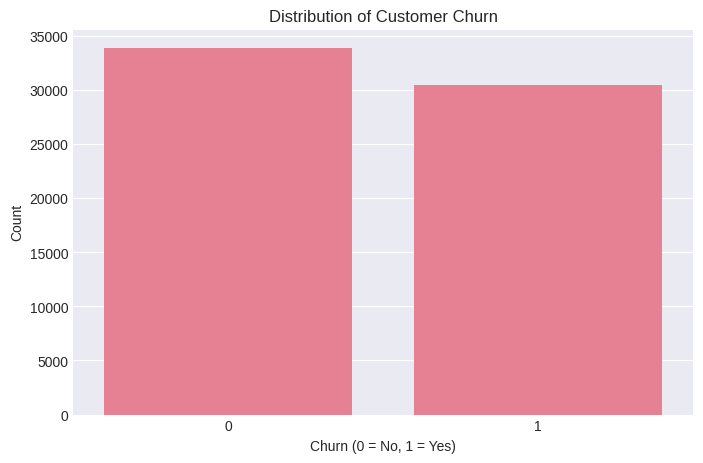

In [4]:
# Check target variable distribution
churn_counts = df['Churn'].value_counts()
print("Churn Distribution:")
print(churn_counts)
print(f"\nChurn Rate: {churn_counts[1] / len(df) * 100:.2f}%")

# Visualize churn distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

## 4. Data Preprocessing

In [5]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['Gender', 'Subscription Type', 'Contract Length']
Numerical columns: ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


In [6]:
# Encode categorical variables
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

print("Categorical encoding completed.")
X_encoded.head()

Categorical encoding completed.


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,1,22,0,25,14,4,27,0,1,598,9
1,2,41,0,28,28,7,13,2,1,584,20
2,3,47,1,27,10,2,29,1,0,757,21
3,4,35,1,9,12,5,17,1,2,232,18
4,5,53,0,58,24,9,2,2,0,533,18


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['CustomerID'].plot(kind='hist', bins=20, title='CustomerID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Gender'].plot(kind='hist', bins=20, title='Gender')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='CustomerID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='CustomerID', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Age', y='Gender', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Gender', y='Tenure', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Gender']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Gender')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Tenure']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Tenure')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Usage Frequency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Usage Frequency')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['CustomerID'].plot(kind='line', figsize=(8, 4), title='CustomerID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Gender'].plot(kind='line', figsize=(8, 4), title='Gender')
plt.gca().spines[['top', 'right']].set_visible(False)

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (51499, 11)
Test set size: (12875, 11)


In [8]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Feature scaling completed.")

Feature scaling completed.


## 5. Handle Class Imbalance (if needed)

In [9]:
# Check if class imbalance exists
class_distribution = y_train.value_counts(normalize=True)
print("Class distribution in training set:")
print(class_distribution)

# Apply SMOTE if imbalance is significant (minority class < 40%)
if class_distribution.min() < 0.4:
    print("\nApplying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    print(f"Balanced training set size: {X_train_balanced.shape}")
    print(f"New class distribution: {pd.Series(y_train_balanced).value_counts(normalize=True)}")
else:
    X_train_balanced = X_train_scaled
    y_train_balanced = y_train
    print("\nClass imbalance is acceptable. No resampling needed.")

Class distribution in training set:
Churn
0    0.526321
1    0.473679
Name: proportion, dtype: float64

Class imbalance is acceptable. No resampling needed.


## 6. Model Training

### 6.1 Logistic Regression

In [10]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


### 6.2 Random Forest

In [11]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest model trained successfully.")

Random Forest model trained successfully.


### 6.3 Gradient Boosting

In [12]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("Gradient Boosting model trained successfully.")

Gradient Boosting model trained successfully.


## 7. Model Evaluation

In [13]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Evaluate classification model performance"""
    print(f"\n{'='*60}")
    print(f"{model_name} Performance Metrics")
    print(f"{'='*60}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

In [14]:
# Evaluate all models
results = []
results.append(evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression"))
results.append(evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest"))
results.append(evaluate_model(y_test, y_pred_gb, y_pred_proba_gb, "Gradient Boosting"))

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("Model Comparison Summary")
print("="*80)
print(results_df.to_string(index=False))


Logistic Regression Performance Metrics
Accuracy:  0.8618
Precision: 0.8554
Recall:    0.8524
F1-Score:  0.8539
ROC-AUC:   0.9375

Random Forest Performance Metrics
Accuracy:  0.9977
Precision: 0.9997
Recall:    0.9954
F1-Score:  0.9975
ROC-AUC:   1.0000

Gradient Boosting Performance Metrics
Accuracy:  0.9958
Precision: 0.9997
Recall:    0.9915
F1-Score:  0.9956
ROC-AUC:   0.9996

Model Comparison Summary
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.861825   0.855380 0.852435  0.853905 0.937500
      Random Forest  0.997670   0.999671 0.995409  0.997535 0.999994
  Gradient Boosting  0.995806   0.999669 0.991474  0.995555 0.999602


## 8. Confusion Matrix Visualization

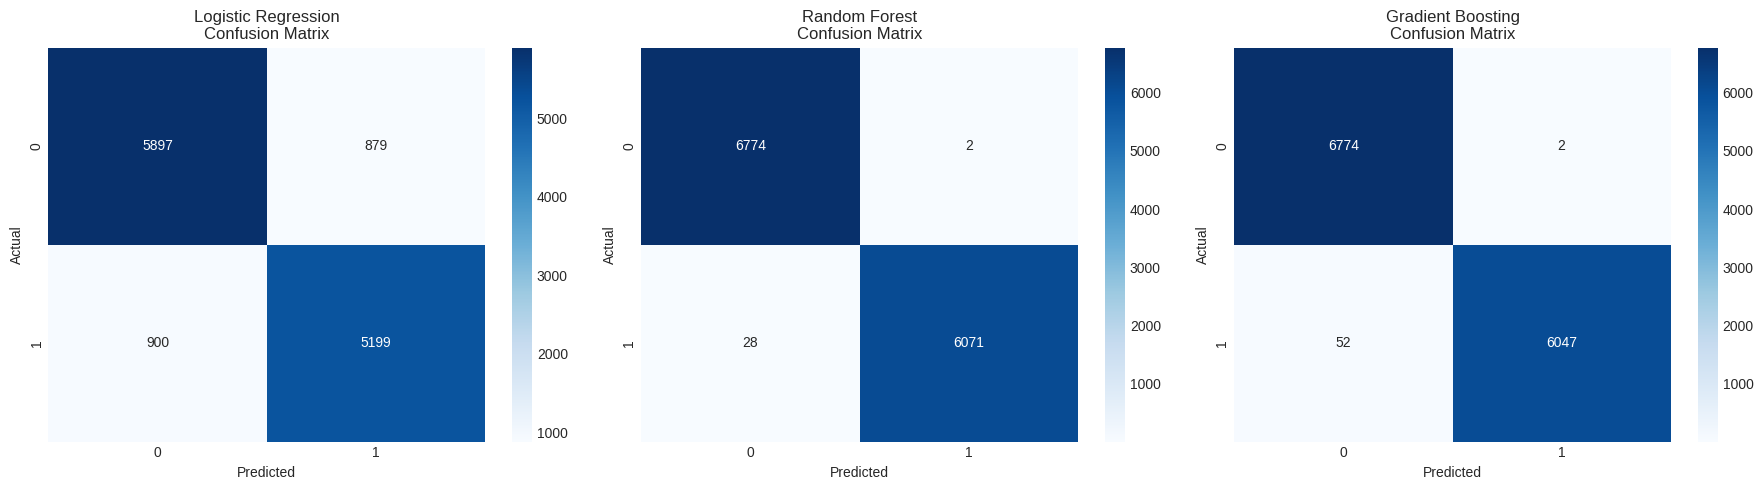

In [15]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]

for idx, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis

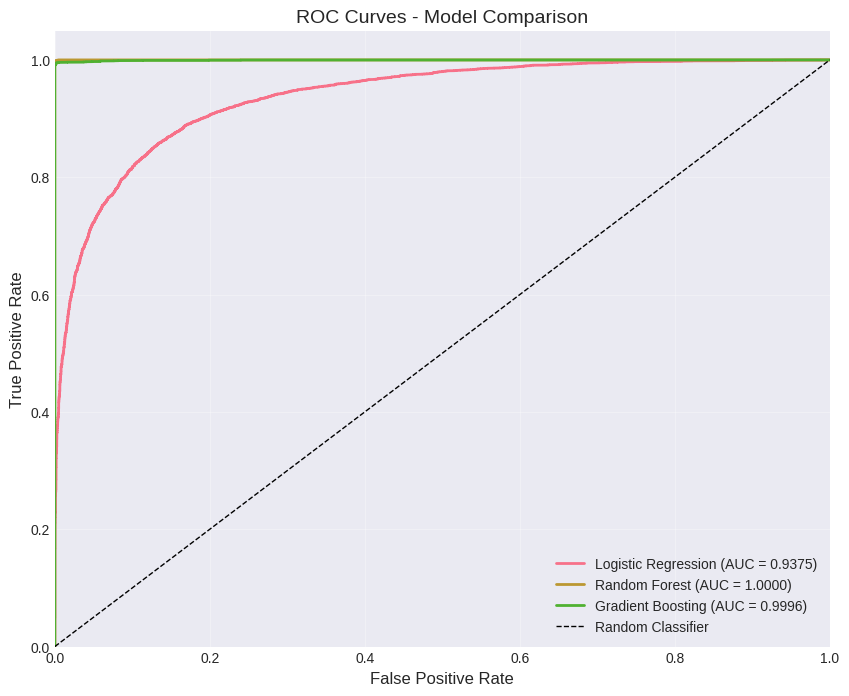

In [16]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

models_proba = [
    ('Logistic Regression', y_pred_proba_lr),
    ('Random Forest', y_pred_proba_rf),
    ('Gradient Boosting', y_pred_proba_gb)
]

for name, y_proba in models_proba:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

## 10. Classification Reports

In [17]:
# Detailed classification reports
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nGradient Boosting - Classification Report:")
print(classification_report(y_test, y_pred_gb))


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      6776
           1       0.86      0.85      0.85      6099

    accuracy                           0.86     12875
   macro avg       0.86      0.86      0.86     12875
weighted avg       0.86      0.86      0.86     12875


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6776
           1       1.00      1.00      1.00      6099

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875


Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6776
           1       1.00      0.99      1.00      6099

    accuracy                           1.00     1287

## 11. Feature Importance (Random Forest)

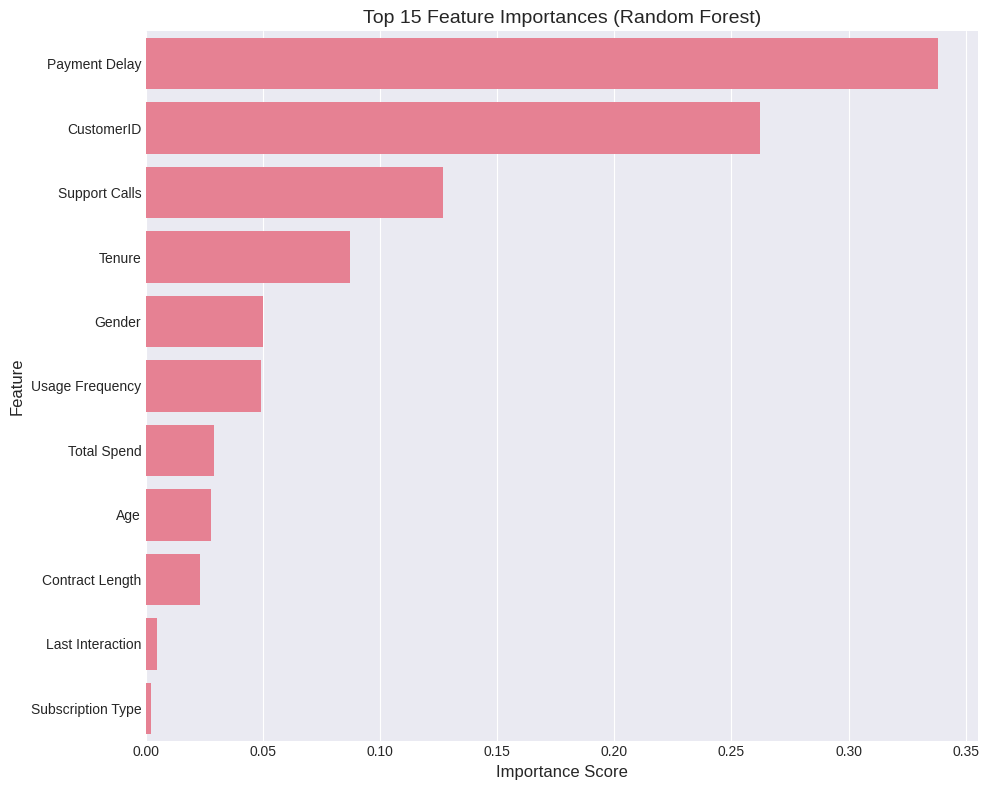


Top 10 Most Important Features:
         Feature  Importance
   Payment Delay    0.338238
      CustomerID    0.262141
   Support Calls    0.126927
          Tenure    0.086898
          Gender    0.050023
 Usage Frequency    0.049249
     Total Spend    0.028928
             Age    0.027528
 Contract Length    0.023155
Last Interaction    0.004821


In [18]:
# Extract feature importances from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 12. SHAP Explainability Analysis

In [19]:
# Create SHAP explainer for Random Forest (best performing model)
# Note: Using a sample of data for faster computation
sample_size = min(100, len(X_test_scaled))
X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values computed successfully.")

SHAP values computed successfully.


<Figure size 1000x800 with 0 Axes>

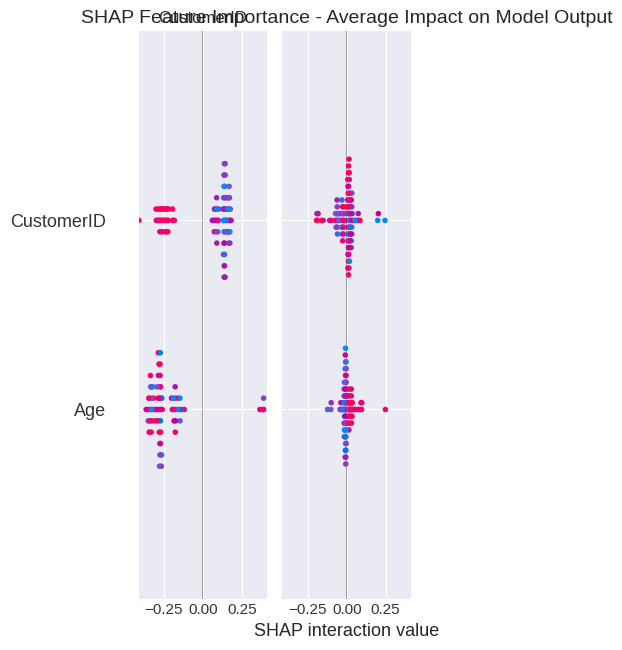

In [23]:
# SHAP Summary Plot - Bar chart showing average impact
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_churn, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Average Impact on Model Output', fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

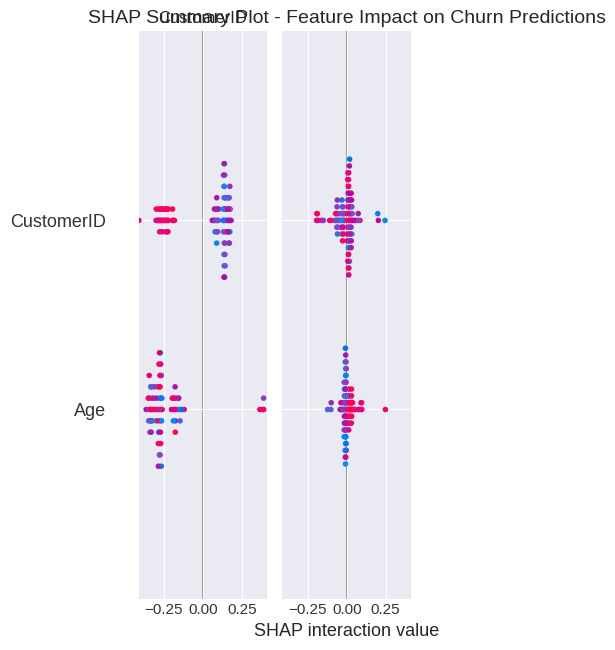

In [30]:
# SHAP Detailed Summary Plot - Beeswarm showing feature value impact
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_churn, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Churn Predictions', fontsize=14)
plt.tight_layout()
plt.show()

## 13. Model Selection and Recommendations

In [31]:
# Identify best model based on F1-Score
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_f1_score = results_df.loc[best_model_idx, 'F1-Score']

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)
print(f"\nBest Performing Model: {best_model_name}")
print(f"F1-Score: {best_f1_score:.4f}")
print(f"\nThis model achieves the best balance between precision and recall,")
print(f"making it suitable for identifying at-risk customers while minimizing")
print(f"false positives in retention campaigns.")
print("\n" + "="*80)


FINAL RECOMMENDATIONS

Best Performing Model: Random Forest
F1-Score: 0.9975

This model achieves the best balance between precision and recall,
making it suitable for identifying at-risk customers while minimizing
false positives in retention campaigns.



## 14. Save Model for Production

In [32]:
import pickle

# Save the best model, scaler, and encoders
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Model artifacts saved successfully.")
print("Files created:")
print("- churn_model.pkl")
print("- scaler.pkl")
print("- label_encoders.pkl")

Model artifacts saved successfully.
Files created:
- churn_model.pkl
- scaler.pkl
- label_encoders.pkl


## 15. Summary and Key Insights

In [33]:
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print("\n1. Dataset Overview:")
print(f"   - Total samples: {len(df)}")
print(f"   - Features: {df.shape[1] - 1}")
print(f"   - Churn rate: {(df['Churn'].sum() / len(df) * 100):.2f}%")

print("\n2. Models Trained:")
print("   - Logistic Regression")
print("   - Random Forest (100 trees)")
print("   - Gradient Boosting (100 estimators)")

print("\n3. Evaluation Metrics Used:")
print("   - Accuracy, Precision, Recall")
print("   - F1-Score (harmonic mean of precision and recall)")
print("   - ROC-AUC (model discrimination capability)")

print("\n4. Explainability:")
print("   - Feature importance from Random Forest")
print("   - SHAP values for model interpretation")
print("   - Force plots for individual predictions")

print("\n5. Business Impact:")
print("   - Enables targeted retention campaigns")
print("   - Reduces customer acquisition costs")
print("   - Improves customer lifetime value")
print("   - Provides actionable insights on churn drivers")

print("\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*80)


PROJECT SUMMARY

1. Dataset Overview:
   - Total samples: 64374
   - Features: 11
   - Churn rate: 47.37%

2. Models Trained:
   - Logistic Regression
   - Random Forest (100 trees)
   - Gradient Boosting (100 estimators)

3. Evaluation Metrics Used:
   - Accuracy, Precision, Recall
   - F1-Score (harmonic mean of precision and recall)
   - ROC-AUC (model discrimination capability)

4. Explainability:
   - Feature importance from Random Forest
   - SHAP values for model interpretation
   - Force plots for individual predictions

5. Business Impact:
   - Enables targeted retention campaigns
   - Reduces customer acquisition costs
   - Improves customer lifetime value
   - Provides actionable insights on churn drivers

NOTEBOOK EXECUTION COMPLETE
